# NumMod 2023 PS3: Code for problem 2

We will use **meshpy** package: https://anaconda.org/conda-forge/meshpy

In [1]:
import scipy as sp
from scipy import io
import scipy.interpolate
import meshpy.triangle
import numpy as np
import numpy.linalg as lin
import matplotlib.pyplot as plt
import math
import scipy.sparse
import scipy.sparse.linalg
from tqdm import tqdm

#### Helpers to save/load mesh

In [2]:
import os.path
mesh_data_dir = "mesh_data"

# Create mesh_data folder
if not os.path.exists(mesh_data_dir):
    os.mkdir(mesh_data_dir)

# Write mesh to a file in order to update it further. 
# Inputs: 
# - mesh (generated by meshpy)
# - facets (pairs of points that define boundary)
# - filename
def write_dat(mesh, facets, filename):
    with open(os.path.join(mesh_data_dir, filename), "w") as f:
        # coordinates of all nodes
        mesh_points = np.array(mesh.points)
        # unique triangles defined as the combination of 3 nodes 
        mesh_tris = np.array(mesh.elements)

        p_count = mesh_points.shape[0]
        t_count = mesh_tris.shape[0]
        f_count = len(facets)

        # write the nodes
        f.write(str(p_count))    
        f.write('\n') 
        for i in range(p_count):
            f.write(str(mesh_points[i][0]))
            f.write(' ')
            f.write(str(mesh_points[i][1]))
            f.write('\n') 

        # write the triangles    
        f.write(str(t_count))
        f.write('\n')
        for i in range(t_count):
            f.write(str(mesh_tris[i][0]))
            f.write(' ')
            f.write(str(mesh_tris[i][1]))
            f.write(' ')
            f.write(str(mesh_tris[i][2]))
            f.write('\n')

        # write the facets    
        f.write(str(f_count))
        f.write('\n')
        for i in range(f_count):
            f.write(str(facets[i][0]))
            f.write(' ')
            f.write(str(facets[i][1]))
            f.write('\n')  

# Read mesh from file
# Return 3 arrays:
# - mp (coordinates of all nodes of the mesh)
# - mt (triangles, defined as the combination of 3 nodes),
# - mf (pairs of points which are on the boundary; the so-called facets)

def read_dat(filename):
    with open(os.path.join(mesh_data_dir, filename), "r") as f:
        points = []

        # read the nodes
        n_points = int(f.readline())
        for i in range(n_points):
            pp = f.readline().split(' ')
            points.append([float(pp[0]),float(pp[1])])

        # read the triangles
        n_tris = int(f.readline())
        tris = []
        for i in range(n_tris):
            tt = f.readline().split(' ')
            tris.append([int(tt[0]),int(tt[1]),int(tt[2])])

        # read the facets
        facets = []
        n_facets = int(f.readline())
        for i in range(n_facets):
            ff = f.readline().split(' ')
            facets.append((int(ff[0]),int(ff[1])))
        
        return np.array(points), np.array(tris),np.array(facets)

---

<br><br><br>

### Triangle helpers

In [3]:
# Area of given triangle
def triangle_area(mp, i):
    mes_tr = abs(0.5*((mp[i[0]][0] - mp[i[2]][0])*(mp[i[1]][1]-mp[i[2]][1])
                     -(mp[i[1]][0] - mp[i[2]][0])*(mp[i[0]][1]-mp[i[2]][1])))
    return mes_tr


# Half-perimeter of a given triangle
def p_triangle(mp, i):
    p = (mp[i[0]][0]**2+mp[i[1]][0]**2 +mp[i[2]][0]**2+mp[i[0]][1]**2+mp[i[1]][1]**2
            + mp[i[2]][1]**2 - 1*(mp[i[0]][0]*mp[i[1]][0]+ mp[i[0]][0]*mp[i[2]][0]+mp[i[1]][0]*mp[i[2]][0]
            + mp[i[0]][1]*mp[i[1]][1]+ mp[i[0]][1]*mp[i[2]][1]+mp[i[1]][1]*mp[i[2]][1]))
    return p


# Norm of function f on given triangle i.
def norm_f(mp, i, f):
    t_area = triangle_area(mp,i)
    norm = 1.0/3*(f(mp[i[0]]) + f(mp[i[1]]) + f(mp[i[2]]))*t_area
    return norm

<br>

### Herpers to create and solve FEM SLA system

This function creates the **stifness matrix** of a single triangle

* We will use expression from the lecture 5 to calculate the matrix $M_{j,k} = |T| (\nabla \eta_j)\cdot(\nabla \eta_k)$
$$
M = \frac{|T|}{2} G G^T
\qquad\text{where}\qquad
G =
\left(
\begin{array}{ccc}
1 & 1 & 1 \\
x _1 & x _2 & x _3 \\
y _1 & y _2 & y _3
\end{array}
\right)^{-1}
\left(
\begin{array}{ccc}
0 & 0 \\
1 & 0 \\
0 & 1
\end{array}
\right)
$$


In [4]:
def stiff_matr_3d(triag, points):
    
    # coordinates of the triangle
    r1 = points[triag[0]]
    r2 = points[triag[1]]
    r3 = points[triag[2]]
    
    # area of triangle 
    S_T = 0.5 * ((r2[0] - r1[0]) * (r3[1] - r1[1]) - (r2[1] - r1[1]) * (r3[0] - r1[0]))
    
    # gradients
    G = np.ones((3, 3))
    G[1:, 0] = r1
    G[1:, 1] = r2
    G[1:, 2] = r3
    G = np.linalg.solve(G, np.array([[0, 0], [1, 0], [0, 1]]))
    
    M = G.dot(G.T) * S_T/2
    
    return M

<br>

Define right hand side function $f$ for the system $Ax = f$

In [5]:
# Constant $f=1$
def right_hand_side(x):
    return 1

<br>

This helper solves **the numerical differential equation** on the mesh. Notation is the same: mesh_points (nodes), mesh_tris (triangles), mesh_facets (facets), f (right-hand-side)

In [6]:
def fem_solve(mesh_points, mesh_tris, mesh_facets, f):
    b = np.zeros(mesh_points.shape[0])
    
    # stifness matrix
    A = sp.sparse.lil_matrix((mesh_points.shape[0], mesh_points.shape[0]))
    for triag in mesh_tris:
        M_T = stiff_matr_3d(triag, mesh_points)
        for k in range(3):
            for l in range(3):
                A[triag[k], triag[l]] += M_T[k, l]

    # right-hand-side
    for triag in mesh_tris:
        r1 = mesh_points[triag[0]]
        r2 = mesh_points[triag[1]]
        r3 = mesh_points[triag[2]]
        S_T = 0.5 * ((r2[0] - r1[0]) * (r3[1] - r1[1]) - (r2[1] - r1[1]) * (r3[0] - r1[0]))

        for k in range(3):
            b[triag[k]] += 1./3 * S_T*f(mesh_points[triag[k]])

    # Dirichlet boundary conditions
    for i in mesh_facets[:, 0]:
        A[i, :] = 0
        A[:, i] = 0
        A[i, i] = 1.
        b[i] = 0
        
    for i in mesh_facets[:, 1]:
        A[i, :] = 0
        A[:, i] = 0
        A[i, i] = 1.
        b[i] = 0
    A = sp.sparse.csc_matrix(A)
    sol = sp.sparse.linalg.spsolve(A, b)
        
    return sol



---

<br><br>

### Helpers to refine mesh

The following function implements the **computation of the gradient on a triangle**. i  is the i-th triangle (triplet of points), points are the points of the mesh, and sol is the solution of our equation. It is used for computing $[\nabla u _h] _{\gamma} = (\nabla u _h) _{T _1} \cdot n _1 + (\nabla u _h) _{T _2} \cdot n _2$, where $\gamma$ is the edge that $T _1$ and $T _2$ share.

In [7]:
def compute_grad(i, points, sol):
    grad = np.zeros(2)
    u1 = sol[i[0]]
    u2 = sol[i[1]]
    u3 = sol[i[2]]
    x1 = points[i[0]][0]
    x2 = points[i[1]][0]
    x3 = points[i[2]][0]
    y1 = points[i[0]][1]
    y2 = points[i[1]][1]
    y3 = points[i[2]][1]
    znam = x3*(y1-y2)+x1*(y2-y3)+x2*(y3-y1)
    if znam == 0:
        znam = 10**-6
    grad[0] = (u3*(y1-y2) + u1*(y2-y3) + u2*(y3-y1))/(znam)
    grad[1] = (u3*(x2-x1) + u2*(x1-x3) + u1*(x3-x2))/(znam)
    return grad    

<br>

This function **constructs the array with all the edges** in the mesh. mt --- triangles, mp --- points

In [8]:
def get_edges(mt, mp):
    A_connect1 = np.zeros((len(mp), len(mp)))
    for i in mt:
        A_connect1[i[0], i[1]] = 1
        A_connect1[i[0], i[2]] = 1
        A_connect1[i[1], i[2]] = 1
    A = A_connect1+A_connect1.T
    set_edges = []
    for i in range(A.shape[0]):
        for j in range(i, A.shape[0]):
            if A[i,j] >0:
                set_edges.append([i,j])
    return set_edges

<br>

Function of **finding which edge has two triangles containing it** (in order to estimate error contributions for each non-Dirichlet edge later on). edges --- array that was generated by get_edges function, mt --- triangles.

In [9]:
def find_triangle_neighbours(edges, mt):
    triangle_neighbours = np.zeros((len(edges),2)) -1
    k = 0
    for i in edges:
        l = 0
        for j in mt:
            edge1 = [j[0], j[1]]
            edge2 = [j[0], j[2]]
            edge3 = [j[1], j[2]]
            if (set(i) == set(edge1)) or (set(i) == set(edge2)) or (set(i) == set(edge3)):
                if triangle_neighbours[k][0]>=0:
                    triangle_neighbours[k][1] = l
                else:
                    triangle_neighbours[k][0] = l
            l = l+1
        k = k+1  
    return triangle_neighbours

<br>

### Edges estimators

The edge estimator **computes the rank for each edge**, and next the worst-ranked edges are refined by adding their middle points to the mesh.

* The first simple estimator uses the following formula: 
$$
I_1[e] = \frac{1}{2}(||f(T_1)||\cdot p^2_{T_1}+||f(T_2)||\cdot p^2_{T_2})
$$
where  $e$  is the edge that  $T_1$  and $T_2$  share,  $p_{T}$ is a half-perimeter of $T$, and $||f(T)||$ is a norm of right hand side function $f$ on $T$.


* The second simple estimator is 
$$
I_2[e] = ((\nabla u_{T_1} - \nabla u_{T_2}), \vec n)^2\cdot|e|^2
$$
where  $e$  is the edge that  $T_1$  and $T_2$  share.


* The good estimator uses both of estimators above (and is expected to give better accuracy and more proper mesh)
$$
I_g[e] = I_1[e] + I_2[e]
$$
where $e$ is an edge.

In [10]:
def simple_1_estimator(neigh, edges, mp, mt, sol, right_hand_side):
    indicator = np.zeros(len(neigh))-1
    for i in range(len(indicator)):
        if not (neigh[i] == -1).any():
            e = mp[edges[i][1]] - mp[edges[i][0]]
            n = [-e[1], e[0]]
            n = n / lin.norm(n)
            
            indicator[i] =  (
                + 0.5*((norm_f(mp, mt[int(neigh[i][0])], right_hand_side)
                *(p_triangle(mp, mt[int(neigh[i][0])]))**2 
                + norm_f(mp, mt[int(neigh[i][1])], right_hand_side)
                *(p_triangle(mp, mt[int(neigh[i][1])]))**2))
            )
            
    return indicator

In [25]:
def simple_2_estimator(neigh, edges, mp, mt, sol, right_hand_side):
    indicator = np.zeros(len(neigh))-1
    for i in range(len(indicator)):
        if not (neigh[i] == -1).any():
            e = mp[edges[i][1]] - mp[edges[i][0]]
            n = [-e[1], e[0]]
            n = n / lin.norm(n)
            du1 = compute_grad(mt[int(neigh[i][0])], mp, sol)
            du2 = compute_grad(mt[int(neigh[i][1])], mp, sol)
            indicator[i] = np.dot(du1 - du2, n)**2*np.dot(e,e)
    return indicator

In [77]:
def good_estimator(neigh, edges, mp, mt, sol, right_hand_side):
    indicator = np.zeros(len(neigh))-1
    for i in range(len(indicator)):
        if not (neigh[i] == -1).any():
            e = mp[edges[i][1]] - mp[edges[i][0]]
            n = [-e[1], e[0]]
            n = n / lin.norm(n)
            du1 = compute_grad(mt[int(neigh[i][0])], mp, sol)
            du2 = compute_grad(mt[int(neigh[i][1])], mp, sol)
            indicator[i] =  (
                + 0.5*((norm_f(mp, mt[int(neigh[i][0])], right_hand_side)
                *(p_triangle(mp, mt[int(neigh[i][0])]))**2 
                + norm_f(mp, mt[int(neigh[i][1])], right_hand_side)
                *(p_triangle(mp, mt[int(neigh[i][1])]))**2))
                +  np.dot(du1 - du2, n)**2*np.dot(e,e)
            )
    return indicator

<br>

<br>

### The most important function 
It **refines the given mesh acording to the rule of refinement.**

In [13]:
def contains(what, where):
    for i in where:
        if (what == i).all():
            return 1
    return 0


def middle_point(segment):
    return (segment[0]+segment[1])/2


def get_refined_mesh_points(mp, mt, right_hand_side, sol, edges_estimator, fraction=0.2):
    # find all edges
    edges = get_edges(mt,mp)
    
    # find neighbouring triangles
    neigh = find_triangle_neighbours(edges, mt)
    
    # estimate ranks for each edge (greater is worse)
    edge_ranks = edges_estimator(neigh, edges, mp, mt, sol, right_hand_side)  
    
    # get the worst edges
    num_edges_to_refine = int(len(mp) * fraction)   
    edges_to_refine = sorted(zip(edge_ranks, edges))[-num_edges_to_refine:]
    edges_to_refine = [edge for (rank, edge) in edges_to_refine]
    
    # refine edge by adding its middle point
    new_points = []
    for edge in edges_to_refine: 
        new_p = middle_point(mp[edge])
        if not contains(new_p, points):
            new_points.append(new_p)

    return np.append(mp,np.array(new_points), axis=0)



Integrate the solution over the domain.

In [14]:
def integrate_over_mesh(mp, mt, sol):
    s = 0
    for i in mt:
        t_area = triangle_area(mp, i)
        
        # mean solution at the vertices by area
        s = s + 1.0/3*(sol[i[0]] + sol[i[1]] + sol[i[2]]) * t_area
    return s

<br>

## Initial mesh
Here we create a simple mesh on a domain.

Create mesh with 64 points


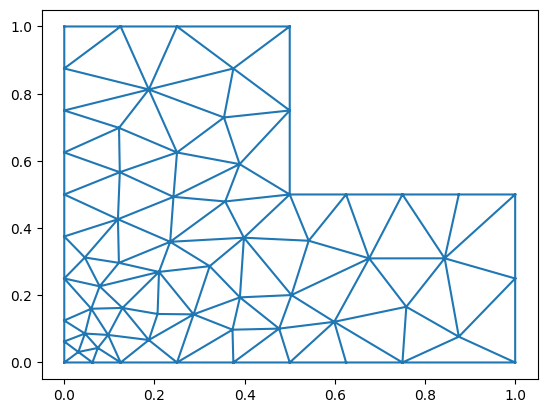

In [15]:
# mesh boundary ponts
points = [ (0,0),(1,0),(1,0.5),(0.5,0.5),(0.5, 1), (0,1) ]


def round_trip_connect(start, end):
    return [(i,i+1) for i in range(start, end)] + [(end, start)]

def needs_refinement(vertices, area):
    # barycenter ==center of mass in our case
    bary = np.sum(np.array(vertices), axis=0) / 3
    dist_center = lin.norm(bary)
    max_area = math.fabs(0.02 * dist_center) + 0.001
    
#     return False
    return area > max_area


# create a mesh
info = meshpy.triangle.MeshInfo()
info.set_points(points)
info.set_facets(round_trip_connect(0, len(points)-1))

mesh = meshpy.triangle.build(info, refinement_func=needs_refinement, min_angle = 30)
print(f"Create mesh with {len(mesh.points)} points")

# save mesh
init_mesh_filename = "init_mesh.dat"
write_dat(mesh,mesh.facets, init_mesh_filename)


# plot mesh
mesh_points = np.array(mesh.points)
mesh_tris = np.array(mesh.elements)
mesh_facets = np.array(mesh.facets)

plt.triplot(mesh_points[:, 0], mesh_points[:, 1], mesh_tris)
plt.show()

## Solve system 

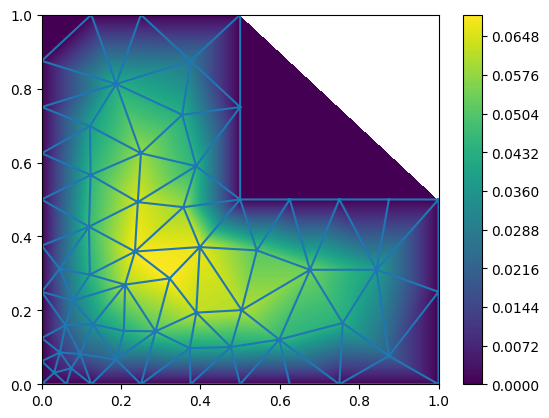

In [16]:
# Solve FEM system on mesh
mp, mt, mf = read_dat(init_mesh_filename)
sol = fem_solve(mp, mt, mf, right_hand_side)


# Plot the solution
xi = np.linspace(0, 1, 100) 
yi = np.linspace(0, 1, 100)
xx, yy = np.meshgrid(xi, yi)
z = scipy.interpolate.griddata(mp, sol, (xx, yy), method="linear")

plt.contourf(xi, yi, z, 200)
plt.triplot(mp[:, 0], mp[:, 1], mt)

plt.colorbar()
plt.show()

---

<br><br>

## Simple 1 algorithm for mesh refinement:

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:27<00:00,  2.78s/it]


Refined mesh have 757 points after 10 iterations.


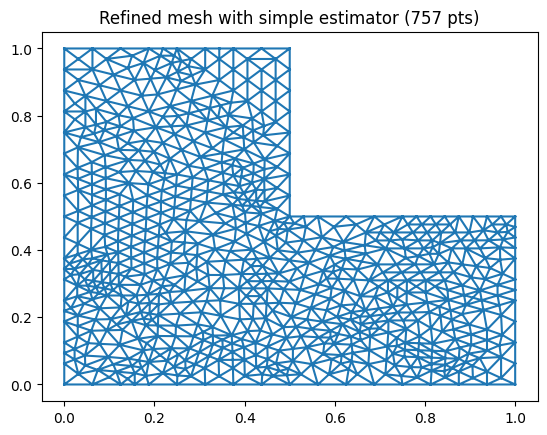

In [17]:
# Refine edges with top 20% of error estimator
num_iters = 10
mesh_filename = "init_mesh.dat"
mesh_suffix="simple_1"


# iteratively refine and save meshes
for step in tqdm(range(num_iters)):
    mp, mt, mf = read_dat(mesh_filename)
    sol = fem_solve(mp, mt, mf, right_hand_side)
    
    # refine the given mesh acording to the rule of refinement
    mp_refined = get_refined_mesh_points(mp, mt, right_hand_side, sol, 
                                         simple_1_estimator, fraction=0.2)
    # create updated mesh
    info_s = meshpy.triangle.MeshInfo()
    info_s.set_points(mp_refined)
    info_s.set_facets(mf)
    mesh = meshpy.triangle.build(info_s, min_angle = 30)
    
    # saving mesh in a file
    mesh_filename = f"ref_mesh_{mesh_suffix}_{step}.dat"
    write_dat(mesh, mesh.facets, mesh_filename)
#---

simple_refined_mesh_filename = mesh_filename

mp, mt, mf = read_dat(simple_refined_mesh_filename)
print(f"Refined mesh have {len(mp)} points after {num_iters} iterations.")


### Plot refined mesh
plt.triplot(mp[:, 0], mp[:, 1], mt)
plt.title(f"Refined mesh with simple estimator ({len(mp)} pts)")
plt.show()

## Simple 2 algorithm for mesh refinement:

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.16it/s]

Refined mesh have 789 points after 5 iterations.


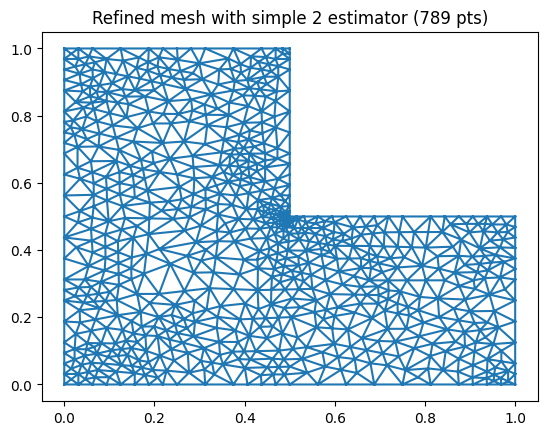

In [52]:
# Refine edges with top 20% of error estimator
num_iters = 5
mesh_filename = "init_mesh.dat"
mesh_suffix="simple_2"


# iteratively refine and save meshes
for step in tqdm(range(num_iters)):
    mp, mt, mf = read_dat(mesh_filename)
    sol = fem_solve(mp, mt, mf, right_hand_side)
    
    # refine the given mesh acording to the rule of refinement
    mp_refined = get_refined_mesh_points(mp, mt, right_hand_side, sol, 
                                         simple_2_estimator, fraction=0.2)
    # create updated mesh
    info_s = meshpy.triangle.MeshInfo()
    info_s.set_points(mp_refined)
    info_s.set_facets(mf)
    mesh = meshpy.triangle.build(info_s, min_angle = 30)
    
    # saving mesh in a file
    mesh_filename = f"ref_mesh_{mesh_suffix}_{step}.dat"
    write_dat(mesh, mesh.facets, mesh_filename)
#---

simple_refined_mesh_filename = mesh_filename

mp, mt, mf = read_dat(simple_refined_mesh_filename)
print(f"Refined mesh have {len(mp)} points after {num_iters} iterations.")


### Plot refined mesh
plt.triplot(mp[:, 0], mp[:, 1], mt)
plt.title(f"Refined mesh with simple 2 estimator ({len(mp)} pts)")
plt.show()

## Refinement using good error estimation

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.22it/s]


Refined mesh have 789 points after 5 iterations.


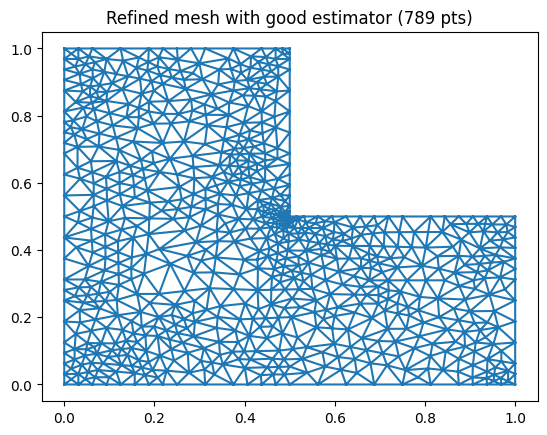

In [78]:
# Refine edges with top 20% of error estimator
num_iters = 5
mesh_filename = "init_mesh.dat"
mesh_suffix="good"


# iteratively refine and save meshes
for step in tqdm(range(num_iters)):
    mp, mt, mf = read_dat(mesh_filename)
    sol = fem_solve(mp, mt, mf, right_hand_side)
    
    # refine the given mesh acording to the rule of refinement
    mp_refined = get_refined_mesh_points(mp, mt, right_hand_side, sol, 
                                         good_estimator, fraction=0.2)
    # create updated mesh
    info_s = meshpy.triangle.MeshInfo()
    info_s.set_points(mp_refined)
    info_s.set_facets(mf)
    mesh = meshpy.triangle.build(info_s, min_angle = 30)
    
    # saving mesh in a file
    mesh_filename = f"ref_mesh_{mesh_suffix}_{step}.dat"
    write_dat(mesh, mesh.facets, mesh_filename)
#---

simple_refined_mesh_filename = mesh_filename

mp, mt, mf = read_dat(simple_refined_mesh_filename)
print(f"Refined mesh have {len(mp)} points after {num_iters} iterations.")


### Plot refined mesh
plt.triplot(mp[:, 0], mp[:, 1], mt)
plt.title(f"Refined mesh with good estimator ({len(mp)} pts)")
plt.show()

## Compare errors

#### Highly refined mesh considered as a reference solution

In [70]:
mp, mt, mf = read_dat("dense_good_mesh.dat")
sol = fem_solve(mp, mt, mf, right_hand_side)

# calculate the norm of the reference solution over the domain
reference_sol = integrate_over_mesh(mp, mt, sol)

#### Simple 1 estimator

In [45]:
pts_grid = []
error_grid = []

num_iters = 10
mesh_suffix="simple_1"

# iteratively refine and save meshes
mesh_filename = "init_mesh.dat"
for step in tqdm(range(num_iters)):
    mp, mt, mf = read_dat(mesh_filename)
    sol = fem_solve(mp, mt, mf, right_hand_side)

    integral_over = integrate_over_mesh(mp, mt, sol)

    pts_grid.append(len(mp))
    error_grid.append(abs(integral_over - reference_sol))   
    
    mesh_filename = f"ref_mesh_{mesh_suffix}_{step}.dat"
    
simple_1_pts_grid = pts_grid
simple_1_error_grid = error_grid

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.03it/s]


#### Simple 2 estimator

In [61]:
pts_grid = []
error_grid = []

num_iters = 5
mesh_suffix="simple_2"

# iteratively refine and save meshes
mesh_filename = "init_mesh.dat"
for step in tqdm(range(num_iters)):
    mp, mt, mf = read_dat(mesh_filename)
    sol = fem_solve(mp, mt, mf, right_hand_side)

    integral_over = integrate_over_mesh(mp, mt, sol)

    pts_grid.append(len(mp))
    error_grid.append(abs(integral_over - reference_sol))   
    
    mesh_filename = f"ref_mesh_{mesh_suffix}_{step}.dat"
    
simple_2_pts_grid = pts_grid
simple_2_error_grid = error_grid

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.35it/s]


#### Good estimator

In [79]:
pts_grid = []
error_grid = []

num_iters = 5
mesh_suffix="good"

# iteratively refine and save meshes
mesh_filename = "init_mesh.dat"
for step in tqdm(range(num_iters)):
    mp, mt, mf = read_dat(mesh_filename)
    sol = fem_solve(mp, mt, mf, right_hand_side)

    integral_over = integrate_over_mesh(mp, mt, sol)

    pts_grid.append(len(mp))
    error_grid.append(abs(integral_over - reference_sol))   
    
    mesh_filename = f"ref_mesh_{mesh_suffix}_{step}.dat"
    
good_pts_grid = pts_grid
good_error_grid = error_grid

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 14.51it/s]


### Plot errors

Method=simple_1 E = 1.23117 * h^-1.03093
Method=simple_2 E = 1.39416 * h^-1.13041
Method=good E = 1.39416 * h^-1.13041


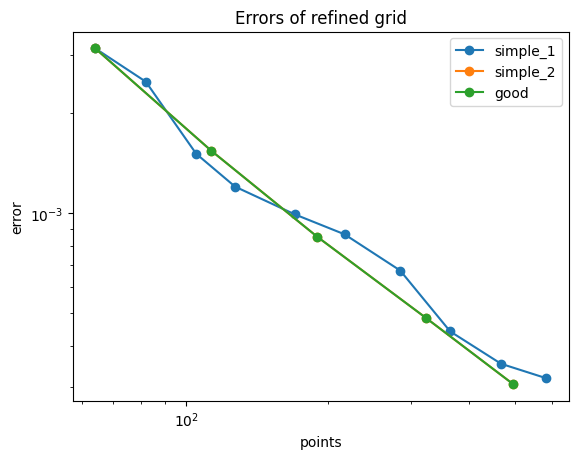

In [80]:
methods = [("simple_1", simple_1_pts_grid, simple_1_error_grid),
           ("simple_2", simple_2_pts_grid, simple_2_error_grid),
           ("good", good_pts_grid, good_error_grid),]


for label, pts_grid, error_grid in methods:
    plt.loglog(pts_grid,error_grid, label=label, marker="o")

    poly_coeffs = np.polyfit(np.log(pts_grid), np.log(error_grid), 1)
    c_const = np.exp(poly_coeffs[1])
    c_power = poly_coeffs[0]   
    print(f"Method={label} E = {np.exp(c_const):.5f} * h^{c_power:.5f}")

plt.title("Errors of refined grid")
plt.xlabel("points")
plt.ylabel("error")
plt.legend()
plt.show()

## Visualize final solution

In [ ]:
# Solve FEM system on mesh
mp, mt, mf = read_dat(f"ref_mesh_good_4.dat")
sol = fem_solve(mp, mt, mf, right_hand_side)


# Plot the solution
xi = np.linspace(0, 1, 100) 
yi = np.linspace(0, 1, 100)
xx, yy = np.meshgrid(xi, yi)
z = scipy.interpolate.griddata(mp, sol, (xx, yy), method="linear")

plt.contourf(xi, yi, z, 200)
plt.triplot(mp[:, 0], mp[:, 1], mt)

plt.colorbar()
plt.show()

#### Min angle check

In [ ]:
for i in mt:
    cos1 = math.acos(np.dot(mp[i[1]]-mp[i[0]],mp[i[2]]-mp[i[0]])/(lin.norm(mp[i[1]]-mp[i[0]])*lin.norm(mp[i[2]]-mp[i[0]])))
    cos2 = math.acos(np.dot(mp[i[2]]-mp[i[0]],mp[i[2]]-mp[i[1]])/(lin.norm(mp[i[2]]-mp[i[0]])*lin.norm(mp[i[2]]-mp[i[1]])))
    cos3 = math.acos(np.dot(mp[i[1]]-mp[i[0]],mp[i[1]]-mp[i[2]])/(lin.norm(mp[i[1]]-mp[i[0]])*lin.norm(mp[i[1]]-mp[i[2]])))
    if cos1 < np.pi/6 or cos2< np.pi/6 or cos3<np.pi/6:
        print(f"Min angle detected for triangle {i}")
    